In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import abc
import numpy as np
import tqdm

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
## Dummy GMM dataset.
# Centers are going to be located on each lattice point of a 5x5 grid.
ndim = 2
centers = torch.tensor([[i, j] for i in range(3) for j in range(3)], dtype=torch.float32)
centers -=torch.tensor([1,1])
n_centers = centers.shape[0]

weights = torch.ones(n_centers)/n_centers

stds = torch.ones(n_centers, ndim) * 0.1

def sample(n_samples):
    center_idxs = torch.multinomial(weights, n_samples, replacement=True)
    samples = centers[center_idxs] + torch.randn(n_samples, ndim) * stds[center_idxs]
    return samples

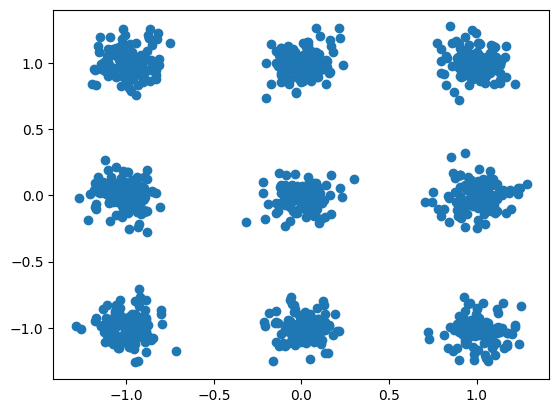

In [98]:
## Sample 1000 points from the GMM.

n_samples = 1000
data = sample(n_samples)

#Plot the data
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1])

In [99]:
n_dataset = 1000000
data = sample(n_dataset)
split = int(n_dataset*0.9)
train_data = data[:split]
test_data = data[split:]

train_dataset = torch.utils.data.TensorDataset(train_data)
test_dataset = torch.utils.data.TensorDataset(test_data)

batch_size = 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [100]:
class ScoreNetwork(nn.Module):
    def __init__(self, ndim, nhidden, depth=3):
        super(ScoreNetwork, self).__init__()
        self.ndim = ndim
        self.nhidden = nhidden
        self.depth = depth
        self.head = nn.Linear(ndim+1, nhidden)
        self.body = nn.ModuleList([nn.Linear(nhidden+1, nhidden) for _ in range(depth-1)])
        self.lns = nn.ModuleList([nn.LayerNorm(nhidden) for _ in range(depth)])
        self.tail = nn.Linear(nhidden+1, ndim)
        self.act = nn.SiLU()
    def forward(self,x,t):
        h= self.lns[0](self.act(self.head(torch.cat([x,t],dim=-1))))
        for i, module in enumerate(self.body):
            h = self.lns[i+1](self.act(module(torch.cat([h, t], dim=-1))))
        return self.tail(torch.cat([h,t], dim=-1))

In [101]:
class ExactScoreNetwork(nn.Module):
    def __init__(self,centers, stds, weights, beta_min = 0.1, beta_max = 20.0, t_min = 1e-4, t_max = 1.0, beta_schedule = 'linear'):
        super(ExactScoreNetwork, self).__init__()
        self.centers = centers.to(device)
        self.stds = stds.to(device)
        self.weights = weights.to(device)
        # Time parameters same as in default ContinuousVPSDE
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.t_min = t_min
        self.t_max = t_max
        self.beta_schedule = beta_schedule
        self.ndim = ndim
        self.n_centers = centers.shape[0]
        if self.t_max < self.t_min:
            raise ValueError('t_max must be greater than t_min')
        if self.t_max != 1.0:
            raise NotImplementedError('t_max != 1.0 is not implemented yet and behavior is not guaranteed')
        self.beta_schedule = beta_schedule
        if beta_schedule == 'linear':
            self.beta = lambda t: (self.beta_min +  (self.beta_max - self.beta_min) * t)
            self.Beta = lambda t: (self.beta_min * t + 1/2*(self.beta_max - self.beta_min) * t**2)
        elif beta_schedule == 'cosine':
            self.beta = lambda t: self.beta_0 + (self.beta_T - self.beta_0)*(1 - torch.cos(np.pi*t))/(2)
            self.Beta = lambda t: self.beta_0 * t + (self.beta_T - self.beta_0)*(t - torch.sin(np.pi*t)/np.pi)/2

    def log_prob(self, x, t):
        # x: (n_samples, ndim)
        # t: (n_samples, 1)
        # returns: (n_samples, 1)
        centers_t = self.centers.unsqueeze(0).repeat(x.shape[0], 1, 1)
        # Forward the centers through the SDE
        Beta_t = self.Beta(t).reshape(-1, 1, 1)
        centers_t = torch.exp(-Beta_t/2)*centers_t
        # Forward the stds through the SDE
        stds_t = self.stds.unsqueeze(0).repeat(x.shape[0], 1,1)
        stds_t_2 = torch.exp(-Beta_t)*stds_t**2 + 1 - torch.exp(-Beta_t) # (n_samples, n_centers, ndim)
        # Weights are not time dependent
        weights_t = self.weights.unsqueeze(0).repeat(x.shape[0], 1)
        x_t = x.unsqueeze(1).repeat(1, self.n_centers, 1)
        prob = torch.exp(-((x_t - centers_t)**2)/(2*stds_t_2)).prod(-1)/(torch.sqrt(2*np.pi*stds_t_2).prod(-1))
        prob = prob * weights_t
        prob = prob.sum(-1)
        return torch.log(prob)
    
    def forward(self, x, t):
        # x: (n_samples, ndim)
        # t: (n_samples, 1)
        # returns: (n_samples, ndim)
        x.requires_grad_(True)
        log_prob = self.log_prob(x, t)
        grad_log_prob = torch.autograd.grad(log_prob.sum(), x, create_graph=True)[0]
        Beta_t = self.Beta(t).reshape(-1, 1)
        return - torch.sqrt(1 - torch.exp(-Beta_t)) * grad_log_prob

In [102]:
# Test the score network
exact_score_network = ExactScoreNetwork(centers, stds, weights)

x = torch.tensor([[-0.9044, -0.9044]]).to(device)
t = torch.tensor([[0.01]]).to(device)
exact_score_network(x, t)

tensor([[0.3527, 0.3527]], device='cuda:0', grad_fn=<MulBackward0>)

In [103]:
class ContinuousSDE(abc.ABC):
    def __init__(self):
        super(ContinuousSDE, self).__init__()
    @abc.abstractmethod
    def foward(self, x_t, t):
        ## Returns the drift and brownian term of the SDE
        pass
    @abc.abstractmethod
    def sampling(self, x, t):
        ## Samples from the SDE at time t and returns x_tilde, the mean and the noise terms
        pass
    @abc.abstractmethod
    def reverse(self, x, t, modified_score):
        ## Returns the drift and brownian term of the reverse SDE for a given modified score
        pass
    @abc.abstractmethod
    def prior_sampling(self, shape):
        pass
    @abc.abstractmethod
    def prior_log_likelihood(self, z):
        pass
    @abc.abstractmethod
    def rescale_additive_to_preserved(self, x, t):
        pass
    @abc.abstractmethod
    def rescale_preserved_to_additive(self, x, t):
        pass
    @abc.abstractmethod
    def noise_level(self, t):
        pass
    @abc.abstractmethod
    def tweedie_reverse(self, x, t, modified_score):
        pass
    @abc.abstractmethod
    def ode_drift(self, x, t, modified_score):
        ## Used for the ODE solver as well as likelihood computations
        pass

class ContinuousVPSDE(ContinuousSDE):
    def __init__(self, beta_min = 0.1, beta_max = 20.0, t_min = 1e-4, t_max = 1.0, beta_schedule = 'linear'):
        super(ContinuousVPSDE, self).__init__()
        self.beta_0 = beta_min
        self.beta_T = beta_max
        self.tmin = t_min
        self.tmax = t_max
        if self.tmax < self.tmin:
            raise ValueError('t_max must be greater than t_min')
        if self.tmax != 1.0:
            raise NotImplementedError('t_max != 1.0 is not implemented yet and behavior is not guaranteed')
        self.beta_schedule = beta_schedule
        if beta_schedule == 'linear':
            self.beta = lambda t: (self.beta_0 +  (self.beta_T - self.beta_0) * t)
            self.Beta = lambda t: (self.beta_0 * t + 1/2*(self.beta_T - self.beta_0) * t**2)
        elif beta_schedule == 'cosine':
            self.beta = lambda t: self.beta_0 + (self.beta_T - self.beta_0)*(1 - torch.cos(np.pi*t))/(2)
            self.Beta = lambda t: self.beta_0 * t + (self.beta_T - self.beta_0)*(t - torch.sin(np.pi*t)/np.pi)/2

    def foward(self, x_t, t):
        ## Returns the drift and brownian term of the forward SDE
        beta_t = self.beta(t).reshape(-1, 1)
        drift = (- beta_t/2)* x_t
        brownian = torch.sqrt(beta_t)*torch.randn_like(x_t)
        return drift, brownian
    
    def sampling(self, x, t):
        ## Samples from the SDE at time t and returns x_tilde, the mean and the rescaled noise terms
        Beta_t = self.Beta(t).reshape(-1, 1)
        mean = torch.exp(-Beta_t/2)*x
        seed = torch.randn_like(x)
        noise = torch.sqrt(1 - torch.exp(-Beta_t))*seed
        x_tilde = mean + noise
        return x_tilde, mean, seed

    def reverse(self, x, t, modified_score):
        beta_t = self.beta(t).reshape(-1, 1)
        sq_1_expB_t = torch.sqrt(1 - torch.exp(-self.Beta(t))).reshape(-1, 1)
        drift = -(beta_t/2 ) * x + (beta_t/sq_1_expB_t)*modified_score 
        brownian = torch.sqrt(beta_t)*torch.randn_like(x)
        return drift, brownian

    def tweedie_reverse(self, x, t, modified_score):
        t = torch.clamp(t, self.tmin, self.tmax)
        Beta_t = self.Beta(t).reshape(-1, 1)
        sq_1_expB_t = torch.sqrt(1 - torch.exp(-Beta_t))
        sq_expBt = torch.exp(-Beta_t/2)
        return (x - sq_1_expB_t*modified_score)/sq_expBt

    def ode_drift(self, x, t, modified_score):
        beta_t = self.beta(t).reshape(-1, 1)
        sq_1_expB_t = torch.sqrt(1 - torch.exp(-self.Beta(t))).reshape(-1, 1)
        drift = (beta_t/2 ) * x - (1/2 * beta_t/sq_1_expB_t)*modified_score 
        return drift

    def prior_sampling(self, shape):
        return torch.randn(shape).to(device)

    def prior_log_likelihood(self, z):
        return 1/2*(z[0].numel()*np.log(2*np.pi) + torch.sum(z**2, dim=[1, 2, 3]))
    
    def rescale_additive_to_preserved(self, x, t):
        return x * torch.exp(-self.Beta(t)/2).reshape(-1, 1)

    def rescale_preserved_to_additive(self, x, t):
        return x / torch.exp(-self.Beta(t)/2).reshape(-1, 1)

    def noise_level(self, t):
        return torch.sqrt(1 - torch.exp(-self.Beta(t)))/torch.exp(-self.Beta(t)/2)
    
    def get_closest_timestep(self, noise_level, n_step_method = 20, method = 'newton'):
        ## Solves the equation noise_level = self.noise_level(t) for t
        ## This is done analytically, noting that noise_level = sqrt(1 - exp(-Beta))/exp(-Beta/2)
        ## We first substitute x = exp(-Beta/2) and solve for x, then we solve for t (simple polynomial)
        if self.beta_schedule == 'linear':
            delta = self.beta_0**2 + 2*(self.beta_T - self.beta_0)*torch.log(1+noise_level**2)
            timesteps = (-self.beta_0 + torch.sqrt(delta))/(self.beta_T - self.beta_0)
            return torch.clamp(timesteps, self.tmin, self.tmax) ## TODO: check if this is correct
        elif self.beta_schedule == 'cosine':
            if type(noise_level) == float or type(noise_level) == int:
                noise_level = torch.tensor(noise_level)
            t_guess = 1/2*torch.ones_like(noise_level)
            if method == 'implicit':
                def implicit_func(t):
                    return (torch.log(1+noise_level**2)+(self.beta_T - self.beta_0)*torch.sin(np.pi*t)/(2*np.pi))*(2/(self.beta_T + self.beta_0))
                ## Solve implicit_func(t) = t
                timesteps = t_guess
                for _ in range(n_step_method):
                    timesteps = implicit_func(timesteps)
            elif method == 'newton':
                def newton_func(t):
                    return (self.beta_T + self.beta_0)/2*t - (torch.log(1+noise_level**2)+(self.beta_T - self.beta_0)*torch.sin(np.pi*t)/(2*np.pi))
                def newton_func_prime(t):
                    return (self.beta_T + self.beta_0)/2 - (self.beta_T - self.beta_0)*torch.cos(np.pi*t)/2
                timesteps = t_guess
                for _ in range(n_step_method):
                    timesteps = timesteps - newton_func(timesteps)/newton_func_prime(timesteps)
            return torch.clamp(timesteps, self.tmin, self.tmax)
        else:
            raise NotImplementedError('The beta schedule {} is not implemented'.format(self.beta_schedule))

In [104]:
class DiffusionModel(nn.Module):
    def __init__(self, sde, network):
        super(DiffusionModel, self).__init__()
        self.sde = sde
        self.network = network

    def loss(self, batch):
        raise NotImplementedError

    def generate_image(self, sample_size, channel, size, sample=None, initial_timestep=None):
        raise NotImplementedError

    def ddim(self, sample_size, channel, size, schedule):
        raise NotImplementedError

In [105]:
def get_schedule(schedule_type, **kwargs):
    """
    Returns a schedule of time steps for a differential equation solver (SDE or ODE)
    Args:
        schedule_type: str, type of schedule
        **kwargs: additional arguments for the schedule
    Returns:
        schedule: torch.Tensor, schedule of time steps
    """
    if schedule_type == 'linear':
        return linear_schedule(**kwargs)
    elif schedule_type == 'power_law':
        return power_law_schedule(**kwargs)
    else:
        raise NotImplementedError

def linear_schedule(**kwargs):
    """
    Returns a linear schedule of time steps for a differential equation solver (SDE or ODE)
    **kwargs should contain the following keys:
        t_min: float, minimum time step
        t_max: float, maximum time step
        n_iter: int, number of time steps
    Args:
        **kwargs: additional arguments for the schedule
    Returns:
        schedule: torch.Tensor, schedule of time steps
        """
    ## TODO parrallelize this
    if 't_min' not in kwargs:
        kwargs['t_min'] = 1e-4
    if 't_max' not in kwargs:
        kwargs['t_max'] = 1
    if 'n_iter' not in kwargs:
        kwargs['n_iter'] = 1000
    if type(kwargs['t_min']) == torch.Tensor:
        assert type(kwargs['t_max']) == torch.Tensor
        return torch.linspace(0,1, kwargs['n_iter']).to(kwargs['t_min'].device).reshape(1,-1) * (kwargs['t_max'] - kwargs['t_min']).unsqueeze(-1) + kwargs['t_min'].unsqueeze(-1)
    return torch.linspace(kwargs['t_min'], kwargs['t_max'], kwargs['n_iter'])

def power_law_schedule(**kwargs):
    """
    Returns a power law schedule of time steps for a differential equation solver (SDE or ODE)
    **kwargs should contain the following keys:
        t_min: float, minimum time step
        t_max: float, maximum time step
        n_iter: int, number of time steps
        power: float, power law exponent
    Args:
        **kwargs: additional arguments for the schedule
    Returns:
        schedule: torch.Tensor, schedule of time steps
    """
    ## TODO parrallelize this
    if 't_min' not in kwargs:
        kwargs['t_min'] = 1e-4
    if 't_max' not in kwargs:
        kwargs['t_max'] = 1
    if 'n_iter' not in kwargs:
        kwargs['n_iter'] = 1000
    if 'power' not in kwargs:
        kwargs['power'] = 1.1
    n_iter = kwargs['n_iter']
    if type(kwargs['t_min']) == torch.Tensor:
        assert type(kwargs['t_max']) == torch.Tensor
        return (torch.linspace(0,1,n_iter)**kwargs['power']).to(kwargs['t_min'].device).reshape(1,-1)* (kwargs['t_max'] - kwargs['t_min']).unsqueeze(-1) + kwargs['t_min'].unsqueeze(-1)
    return torch.linspace(0,1,n_iter)**kwargs['power'] * (kwargs['t_max'] - kwargs['t_min']) + kwargs['t_min']

class EulerMaruyama():
    """
    Euler-Maruyama method for solving stochastic differential equations
    """
    def __init__(self, schedule):
        self.schedule = schedule

    def forward(self, x_init, f, gdW, reverse_time = True, verbose = False):
        """
        Solves the SDE dx = f(x, t) dt + g(x, t) dW_t
        Args:
            x_init: torch.Tensor, initial value of x
            f: function, drift term
            gdW: function, diffusion term (should also contain the random part of the diffusion term, will only be multiplied by sqrt(dt) in the solver)
            reverse_time: bool, whether to reverse the time schedule (used for backward SDEs)
            verbose: bool, whether to print progress bar
        Returns:
            x: torch.Tensor, a sample from the SDE at the final time step
        """
        if reverse_time:
            times = self.schedule
            times = times.flip(1)
        else:
            times = self.schedule
        x = x_init

        progress_bar = tqdm.tqdm(total = len(times)-1, disable=not verbose)
        for i in range(times.shape[1]-1):
            dt = (times[:,i+1] - times[:,i]).reshape(-1,1)
            timesteps = times[:,i].to(x.device).unsqueeze(1)
            x = x + f(x, timesteps) * dt + gdW(x, timesteps) * torch.sqrt(torch.abs(dt))
            if x.isnan().any():
                print("Nan encountered at time step {}".format(i))
                break
            progress_bar.update(1)
        if reverse_time:
            times = x.flip(0) ## flip back to the original time order
        return x

In [106]:
class ContinuousSBM(DiffusionModel):
    def __init__(self, sde, network):
        super(ContinuousSBM, self).__init__(sde, network)
        self.sde = sde
        self.network = network
        self.tmin = self.sde.tmin
        self.tmax = self.sde.tmax

        ## TODO add : option for uneven timesteps sampling when computing the loss -> DONE by SDE

    def loss(self, batch):
        timesteps = (torch.rand(batch.shape[0],1).to(device) * (self.tmax - self.tmin) + self.tmin)
        batch_tilde, _ , rescaled_noise = self.sde.sampling(batch, timesteps)
        rescaled_noise_pred = self.network(batch_tilde, timesteps)
        return F.mse_loss(rescaled_noise_pred, rescaled_noise)
        
    def generate_image(self, sample_size, sample=None, initial_timestep=None, verbose=False, schedule = None, solver = None):
        self.eval()
        if schedule is None:
            if initial_timestep is None:
                t_min = torch.tensor([self.sde.tmin]).repeat(sample_size).to(device)
                t_max = torch.tensor([self.sde.tmax]).repeat(sample_size).to(device)
            else:
                t_min = torch.tensor([self.sde.tmin]).repeat(sample_size).to(device)
                t_max = torch.tensor([initial_timestep]).repeat(sample_size).to(device)
            schedule = get_schedule('linear', t_min = t_min, t_max = t_max, n_iter = 1000)
        
        if solver is None:
            solver = EulerMaruyama(schedule)

        if sample is None:
            ndim = self.network.ndim
            sample = self.sde.prior_sampling((sample_size, ndim)).to(device)
        ## TODO more efficient for f, g? -> ok for our solver but not for others 
        def f(x_t, t):
            model_output = self.network(x_t, t)
            return self.sde.reverse(x_t, t, model_output)[0]
        print(f(sample, schedule[0]), sample)
        def gdW(x_t, t):
            dummy_output = torch.zeros_like(x_t)
            return self.sde.reverse(x_t, t, dummy_output)[1]
        if type(self.network) == ExactScoreNetwork:
                gen = solver.forward(sample, f, gdW, reverse_time = True, verbose = verbose)
        else:
            with torch.no_grad():
                gen = solver.forward(sample, f, gdW, reverse_time = True, verbose = verbose)
        return gen

    def ode_sampling(self, sample_size, sample = None, initial_timestep = None, verbose=True): ## TODO scheduler maybe only in continuous time? 
        self.eval()
        raise NotImplementedError("Not implemented yet")
        channel, size = self.network.in_c, self.network.sizes[0]
        if initial_timestep is None:
            tot_steps = self.sde.N
        else:
            tot_steps = initial_timestep
        with torch.no_grad():
            timesteps = list(range(tot_steps))[::-1]
            if sample is None:
                sample = self.sde.prior_sampling((sample_size, channel, size, size))
            progress_bar = tqdm.tqdm(total=tot_steps, disable=not verbose)
            for t in timesteps:
                time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
                residual = self.network(sample, time_tensor)
                sample = self.ode_step(residual, time_tensor[0], sample)
                progress_bar.update(1)
            progress_bar.close()

        return sample
    
    def log_likelihood(self, batch, initial_timestep = None, verbose=True, repeat = 1):
        '''Sample in forward time the ODE and compute the log likelihood of the batch, see [REF]'''
        self.eval()
        raise NotImplementedError("Not implemented yet")
        log_likelihood = torch.zeros(len(batch)).to(device)
        with torch.no_grad():
            N = self.sde.N
            progress_bar = tqdm.tqdm(total=N, disable=not verbose)
            for i in range(N):
                timesteps = torch.tensor([i]).repeat(len(batch)).to(device)
                modified_score = self.network(gen, timesteps)
                gen -= self.sde.ode_drift(gen, timesteps, modified_score)
                progress_bar.update(1)
                log_likelihood_increase = 0
                with torch.enable_grad():
                    for _ in range(repeat):
                        epsilon = torch.randn_like(batch)
                        gen.requires_grad = True
                        reduced = torch.sum(modified_score * epsilon)
                        grad = torch.autograd.grad(reduced, gen, create_graph=True)[0]
                        gen.requires_grad = False
                        log_likelihood_increase += torch.sum(grad * epsilon, dim=(1, 2, 3))
                        ## TODO add zero grad
                log_likelihood_increase /= repeat
                log_likelihood += log_likelihood_increase/(N-initial_timestep)
            progress_bar.close()
            log_likelihood += self.sde.prior_log_likelihood(batch)
        self.train()
        return log_likelihood

In [107]:
sde = ContinuousVPSDE()
score_net = ScoreNetwork(2,100,6).to(device)
ema_score_net_dict = score_net.state_dict().copy()

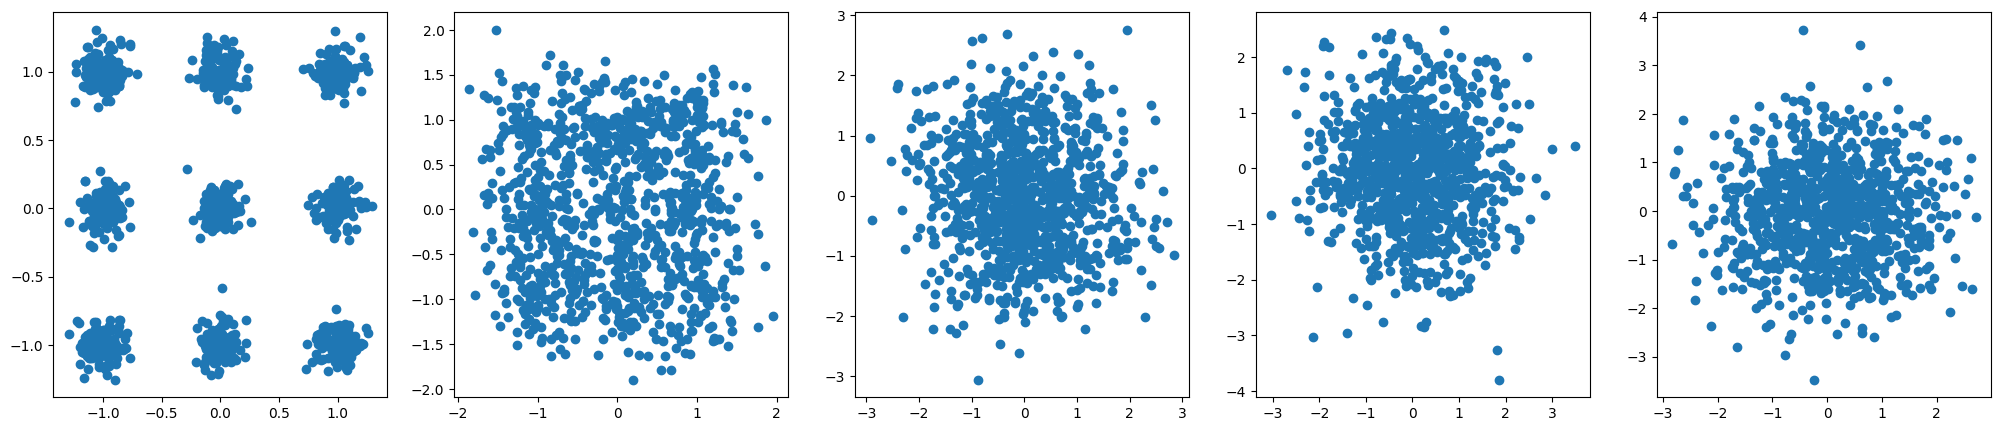

In [108]:
# Test the sde object sampling method for different timesteps (0, 0.1, 0.3, 0.5 and 1)
fig, ax = plt.subplots(1, 5, figsize = (25, 5))
times = [0, 0.1, 0.3, 0.5, 1]
samples = sample(1000)
for i, t in enumerate(times):
    timesteps = torch.ones(1000)*t
    noisy_samples, _, _ = sde.sampling(samples, timesteps)
    ax[i].scatter(noisy_samples[:,0], noisy_samples[:,1])

In [109]:
dm = ContinuousSBM(sde, score_net).to(device)

In [110]:
lr = 1e-4
nepochs = 100

optimizer = optim.Adam(dm.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=90, gamma=0.99)

In [111]:
ema_beta = 0.9

In [112]:
losses = []

In [113]:
progress_bar = tqdm.tqdm(total=nepochs)
for epoch in range(nepochs):
    break
    for batch in train_loader:
        batch=batch[0].to(device)
        loss = dm.loss(batch)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
    if epoch<7:
        ema_score_net_dict = score_net.state_dict().copy()
    else:
        target_state_dict = score_net.state_dict().copy()
        for key in target_state_dict.keys():
           ema_score_net_dict[key] = ema_beta * ema_score_net_dict[key] + (1 - ema_beta) * target_state_dict[key]
    progress_bar.update(1)
progress_bar.close()

  0%|          | 0/100 [00:00<?, ?it/s]


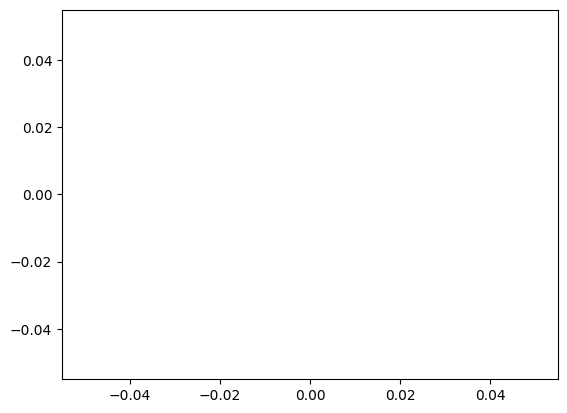

In [114]:
plt.plot(losses)

In [115]:
score_net.load_state_dict(ema_score_net_dict)

<All keys matched successfully>

In [116]:
exact_score_net = ExactScoreNetwork(centers, stds, weights).to(device)
exact_dm = ContinuousSBM(sde, exact_score_net).to(device)

In [117]:
x = sample(10000).to(device)
t = torch.ones(10000).to(device)*1
init_sample, _, _ = sde.sampling(x, t)
init_sample.shape

torch.Size([10000, 2])

In [118]:
## Generate 1000 datapoints and plot them
n_samples = 1000
t = torch.ones(n_samples).to(device)*1
tmin = torch.ones(n_samples).to(device)*sde.tmin
schedule = power_law_schedule(t_min = tmin, t_max = t, n_iter = 1000, power = 2)
samples = exact_dm.generate_image(n_samples, schedule = schedule.to(device))

tensor([[-4.4940,  0.2899],
        [-2.3338, -1.4184],
        [ 3.0982,  2.0118],
        ...,
        [-0.8584, -3.5419],
        [ 1.2503, -8.7730],
        [18.8113, 13.6799]], device='cuda:0', grad_fn=<AddBackward0>) tensor([[-0.4501,  1.0336],
        [ 0.7749, -1.1449],
        [-0.6996,  0.4911],
        ...,
        [-0.0862, -0.3556],
        [ 0.1253, -0.8790],
        [ 1.8811,  1.3680]], device='cuda:0', requires_grad=True)


In [119]:
0.6627/0.4783

1.3855320928287684

In [120]:
1.2852/0.9276

1.3855109961190168

In [121]:
samples = samples.cpu().detach().numpy()

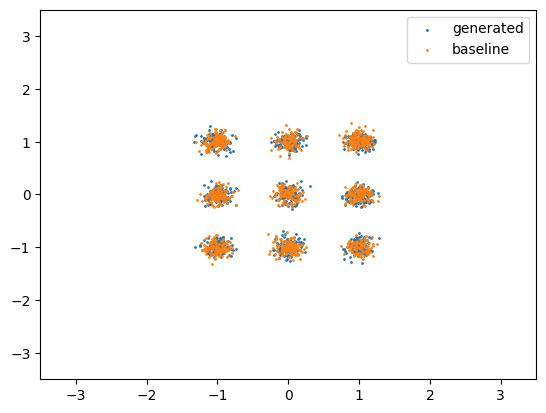

In [122]:
## Plot generated samples
plt.scatter(samples[:,0], samples[:,1], label = 'generated', s=1)
baseline = sample(n_samples)
plt.scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1)
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.legend()

In [123]:
samples.std(0), samples.mean(0)

(array([0.82913584, 0.8169315 ], dtype=float32),
 array([-0.02705549, -0.01462197], dtype=float32))

In [124]:
baseline.std(0), baseline.mean(0)

(tensor([0.8316, 0.8334]), tensor([-0.0246,  0.0161]))

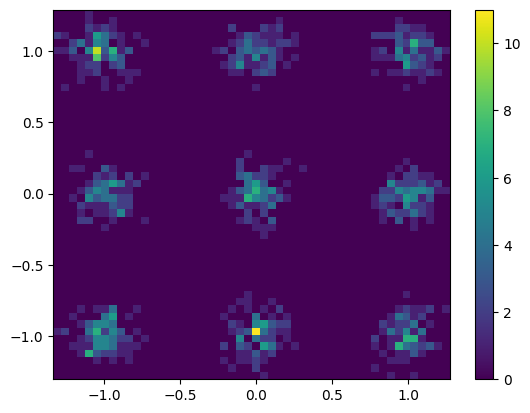

In [125]:
## Empirical distribution of the generated samples
plt.hist2d(samples[:,0], samples[:,1], bins = 50)
plt.colorbar()

In [126]:
baseline = baseline.numpy()

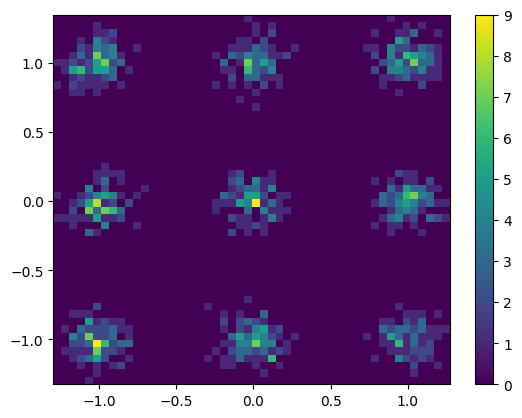

In [127]:
## Empirical distribution of the baseline samples
plt.hist2d(baseline[:,0], baseline[:,1], bins = 50)
plt.colorbar()

In [128]:
x_test = torch.ones(1,2)
t_test = torch.ones(1,1)*sde.tmin

score_net(x_test.to(device), t_test.to(device))

tensor([[0.0923, 0.6174]], device='cuda:0', grad_fn=<AddmmBackward0>)